In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import copy
import os
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandAugment

# =========================
# 1. Config
# =========================
data_dir = "/kaggle/input/data-snake/kaggle/working/data"   # Cấu trúc thư mục: data/train, data/val
num_classes = 124
batch_size = 32
num_epochs = 30
lr = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# 2. Data Augmentation
# =========================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transform)
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# =========================
# 3. Model
# =========================
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)  # pretrained EfficientNetV2-S
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# =========================
# 4. Loss, Optimizer, Scheduler
# =========================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ================================
# 5. Checkpoint helpers
# ================================
def save_checkpoint(model, optimizer, scheduler, epoch, history, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history
    }
    torch.save(checkpoint, path)
    print(f"✅ Saved checkpoint at {path}")

def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    history = checkpoint['history']
    print(f"✅ Loaded checkpoint from {path} (epoch {epoch})")
    return model, optimizer, scheduler, epoch, history

# =========================
# 6. Training Loop
# =========================
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Lưu history
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(model, optimizer, scheduler, epoch+1, history, "/kaggle/working/best_checkpoint.pth")
        
        # Lưu checkpoint mỗi 5 epoch
        if (epoch + 1) % 5 == 0:
            save_checkpoint(model, optimizer, scheduler, epoch+1, history, f"/kaggle/working/checkpoint_epoch{epoch+1}.pth")
        
        print()
    
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

# =========================
# 7. Run Training
# =========================
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

# Save final best model
torch.save(model.state_dict(), "/kaggle/working/swin_tiny_best.pth")
print("✅ Training complete and best model saved.")


Epoch 1/30
--------------------
train Loss: 3.5396 Acc: 0.2904
val Loss: 2.2612 Acc: 0.5720
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 2/30
--------------------
train Loss: 2.2167 Acc: 0.5884
val Loss: 1.6781 Acc: 0.7269
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 3/30
--------------------
train Loss: 1.8145 Acc: 0.6959
val Loss: 1.4432 Acc: 0.8028
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 4/30
--------------------
train Loss: 1.6194 Acc: 0.7553
val Loss: 1.3481 Acc: 0.8291
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 5/30
--------------------
train Loss: 1.5082 Acc: 0.7903
val Loss: 1.2717 Acc: 0.8523
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth
✅ Saved checkpoint at /kaggle/working/checkpoint_epoch5.pth

Epoch 6/30
--------------------
train Loss: 1.4159 Acc: 0.8203
val Loss: 1.2417 Acc: 0.8622
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 7/30
--------------------
tr

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


# =========================
# 7. Evaluation on Test Set
# =========================
# Load lại test dataset
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Lấy mapping index -> class name
class_names = test_dataset.classes
num_classes = len(class_names)

# Load best model đã save
model = models.efficientnet_v2_s(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# --- Load checkpoint ---
checkpoint_path = "/kaggle/working/best_checkpoint.pth"  # thay bằng checkpoint bạn muốn
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Cách thuần tuý
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# =========================
# 8. Tính accuracy
# =========================
overall_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {overall_acc:.4f}")

# =========================
# 9. Accuracy từng class
# =========================
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

print("\nAccuracy theo từng class:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
    correct = np.sum(all_preds[idx] == all_labels[idx])
    total = np.sum(idx)
    print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")

# =========================
# 10. Classification Report (optional)
# =========================
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Test Accuracy: 0.9133

Accuracy theo từng class:
Achalinus_rufescens        Acc: 1.0000  (13/13)
Achalinus_spinalis         Acc: 0.9286  (13/14)
Acrochordus_granulatus     Acc: 0.9535  (41/43)
Acrochordus_javanicus      Acc: 0.8750  (7/8)
Ahaetulla_fusca            Acc: 0.8889  (24/27)
Ahaetulla_prasina          Acc: 1.0000  (20/20)
Ahaetulla_rufusoculara     Acc: 0.8889  (8/9)
Amphiesma_stolatum         Acc: 0.9474  (72/76)
Blue-lipped_sea_krait      Acc: 0.9634  (79/82)
Boiga_cyanea               Acc: 0.9494  (75/79)
Boiga_guangxiensis         Acc: 0.6250  (5/8)
Boiga_jaspidea             Acc: 0.9756  (40/41)
Boiga_kraepelini           Acc: 0.8806  (59/67)
Boiga_multomaculata        Acc: 0.9500  (95/100)
Boiga_siamensis            Acc: 0.8387  (26/31)
Bungarus_candidus          Acc: 0.9437  (67/71)
Bungarus_fasciatus         Acc: 1.0000  (86/86)
Calamaria_septentrionalis  Acc: 0.7273  (16/22)
Calliophis_maculiceps      Acc: 0.9444  (17/18)
Calloselasma_rhodostoma    Acc: 0.9608  (98

🏆 Best Validation Accuracy: 0.9204 (Epoch 29)


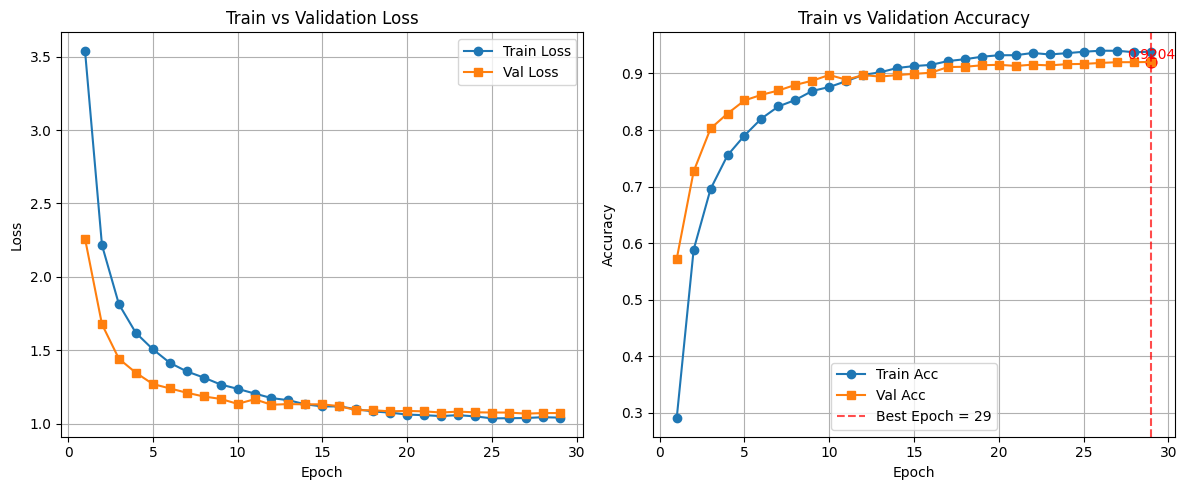

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# 1. Load checkpoint
# =========================
checkpoint_path = "/kaggle/working/best_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
history = checkpoint['history']

# =========================
# 2. Tạo biến epoch & tìm best acc
# =========================
train_acc = history["train_acc"]
val_acc = history["val_acc"]
train_loss = history["train_loss"]
val_loss = history["val_loss"]

epochs = range(1, len(train_acc) + 1)
best_val_acc = max(val_acc)
best_epoch = np.argmax(val_acc) + 1

print(f"🏆 Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

# =========================
# 3. Vẽ Loss và Accuracy
# =========================
plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'o-', label="Train Loss")
plt.plot(epochs, val_loss, 's-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'o-', label="Train Acc")
plt.plot(epochs, val_acc, 's-', label="Val Acc")
plt.axvline(best_epoch, color='r', linestyle='--', alpha=0.7, label=f"Best Epoch = {best_epoch}")
plt.scatter(best_epoch, best_val_acc, color='red', s=60)
plt.text(best_epoch, best_val_acc + 0.005, f"{best_val_acc:.4f}", color='red', ha='center')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
print("\n⚠️ Các class dưới 70% accuracy:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
        correct, total = 0, 0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
        correct = np.sum(all_preds[idx] == all_labels[idx])
        total = np.sum(idx)

    if acc < 0.7:  # dưới 70%
        print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")



⚠️ Các class dưới 70% accuracy:
Boiga_guangxiensis         Acc: 0.6250  (5/8)
Enhydris_subtaeniata       Acc: 0.6000  (6/10)
Erpeton_tentaculatum       Acc: 0.5556  (5/9)
Hebius_khasiensis          Acc: 0.6000  (3/5)
Lycodon_chapaensis         Acc: 0.6000  (6/10)
Lycodon_truongi            Acc: 0.2500  (2/8)
Naja_siamensis             Acc: 0.6667  (8/12)
Oligodon_cyclurus          Acc: 0.5000  (5/10)
Pareas_monticola           Acc: 0.6000  (3/5)
Plagiopholis_nuchalis      Acc: 0.5714  (4/7)
Sinomicrurus_peinani       Acc: 0.2500  (2/8)
Trimeresurus_albolabris    Acc: 0.6875  (11/16)


In [11]:
import torch
from torchvision import transforms, datasets, models
from PIL import Image
import requests
from io import BytesIO
import os

# =====================
# 1. Cấu hình
# =====================
num_classes = 124
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================
# 2. Load model
# =====================
model = models.efficientnet_v2_s(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# --- Load checkpoint ---
checkpoint_path = "/kaggle/working/best_checkpoint.pth"  # thay bằng checkpoint bạn muốn
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# =====================
# 3. Transform
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# =====================
# 4. Lấy class_names từ folder train
# =====================
data_dir = "/kaggle/input/data-snake/kaggle/working/data"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'))
class_names = train_dataset.classes

# =====================
# 5. Hàm dự đoán
# =====================
def predict_from_url(url, class_names):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()

    print(f"Predicted class: {class_names[pred_idx]} (prob = {probs[0][pred_idx]:.4f})")
    return class_names[pred_idx]

# =====================
# 6. Ví dụ sử dụng
# =====================
url = "https://vietnamsnakes.com/storage/snakes/species/46/1748341202_0.jpg"
predict_from_url(url, class_names)


Predicted class: Bungarus_fasciatus (prob = 0.8914)


'Bungarus_fasciatus'